In [6]:
import numpy as np
import pandas as pd
import os

In [7]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')

In [8]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def get_KR(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 10, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def calculate_improvements(KR_before, idx, neighbours, improvements, df = df):
    for neighbour, improvement in zip(
        neighbours, 
        np.nditer(improvements, op_flags = ['readwrite'])
    ):
        swap(idx, neighbour)
        improvement[...] = np.float64(get_KR() - KR_before)
        swap(idx, neighbour)
        
def search_for_the_best_neighbour(neighbours, improvements):
    if improvements.min() > 0:
        return False
    idx_min = improvements.argmin() # index najmniejszego elementu
    return neighbours[idx_min]

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch
    
def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")

In [22]:
np.random.seed(42)

def hill_climbing_algorithm(
    number_of_iterations = 1000, 
    break_counter = 10, 
    neighbours_count = 20
):
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    improvements = np.zeros(neighbours_count)
    idx = np.random.randint(len(df))
    
    while number_of_iterations and break_counter:
        KR_before = get_KR() # początkowa wartość kombinacji
        neighbours = get_neighbours(idx, neighbours_count=neighbours_count) # lista sąsiadów
        # obliczanie potencjalnych ulepszeń dla sąsiadów
        calculate_improvements(KR_before, idx, neighbours, improvements)
        # wyszukanie sąsiada dla którego ulepszenie będzie największe
        best_neighbour = search_for_the_best_neighbour(neighbours, improvements)

        # jeżeli istnieje sąsiad po zamianie z którym ulepszymy kombinacje
        if best_neighbour:
            # zamiana miejscami z sąsiadem
            move(idx, best_neighbour)
            # obliczanie obecnej kombinacji
            KR_now = get_KR()
            # kolejna iteracja rozpoczyna się od miejsca na które wskoczył idx
            idx = best_neighbour  
            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                "Wartosc kombinacji": KR_now
            }, ignore_index=True)

            number_of_iterations -= 1
        else:
            break_counter -= 1
            
    order = df["Zadanie"]
    
    return order, optimalization

## Sprawdzanie różnych wartości parametrów

In [23]:
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=20,
    neighbours_count=20
)

In [24]:
print(new_optimalization)

   Wartosc kombinacji
0           184691699
1           184409578
2           183972387
3           183615579
4           183067441
5           182716189
6           182381173
7           182118824
8           181852442
9           181355810
10          181129546
11          181053465
12          181028867
13          180996599
14          180979023
15          180974864
16          180970378


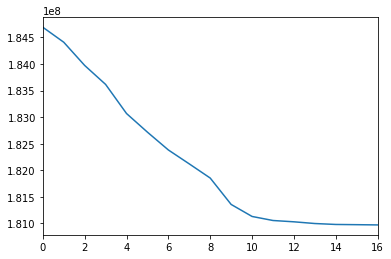

In [25]:
plot_optimalization(new_optimalization)

In [26]:
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=10000,
    break_counter=20,
    neighbours_count=20
)

In [27]:
print(new_optimalization)

   Wartosc kombinacji
0           180728416
1           180391514
2           179987804
3           179684858
4           179388144
5           179000894
6           178585652
7           178341862
8           177976541
9           177577181
10          177381555
11          177063561
12          176759375
13          176480395
14          176179933
15          175715725
16          175232925
17          174905823
18          174628271
19          174389727
20          174287727


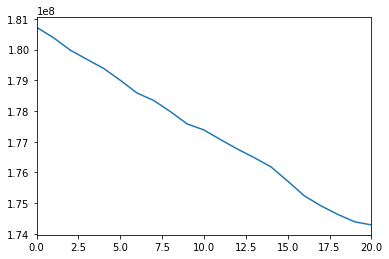

In [28]:
plot_optimalization(new_optimalization)

In [32]:
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=100,
    neighbours_count=20
)


In [33]:
print(new_optimalization)

   Wartosc kombinacji
0           153844169
1           153615789
2           153468935
3           153400468
4           153225394
5           153096324
6           152923842
7           152770798
8           152431778
9           152193274
10          151836186
11          151646207
12          151512254
13          151430972
14          151363793
15          151319298
16          151283580
17          151265196
18          151224411
19          151184836
20          151141090
21          151114685
22          151094075
23          151082939
24          151066316
25          151061275
26          151051945
27          151046942
28          151043532


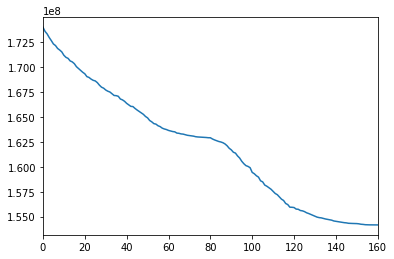

In [30]:
plot_optimalization(new_optimalization)

In [70]:
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=20,
    neighbours_count=6
)


In [71]:
print(new_optimalization)

   Wartosc kombinacji
0            43646977
1            43621994
2            43605095
3            43553476
4            43543651
5            43522485
6            43465795
7            43445931
8            43421176
9            43374316
10           43337605
11           43325661
12           43275605
13           43262237
14           43256750
15           43251386
16           43210830
17           43200730
18           43168338
19           43163546
20           43151110
21           43143934
22           43131218
23           43119614
24           43096066
25           43088984
26           43028991
27           43003480
28           42966988
29           42966032


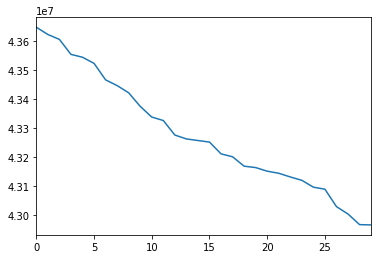

In [72]:
plot_optimalization(new_optimalization)

In [106]:
%%time
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=1000000,
    break_counter=1000,
    neighbours_count=50
)

Wall time: 1min 52s


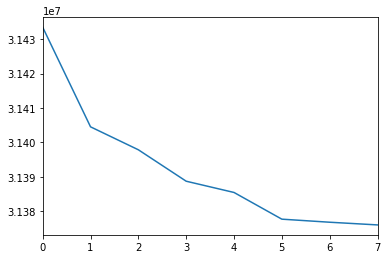

In [120]:
plot_optimalization(new_optimalization)

In [108]:
print(new_optimalization)

   Wartosc kombinacji
0            39002485
1            38963408
2            38884950
3            38849686
4            38789832
5            38771592
6            38737352
7            38715050
8            38652104
9            38619804
10           38592444
11           38578574
12           38534732
13           38515728
14           38406218
15           38383486
16           38340298
17           38330883
18           38317189
19           38306590
20           38299524
21           38255492
22           38248968
23           38246900
24           38243637
25           38194931
26           38187047
27           38185294
28           38174488
29           38172516
30           38158006
31           38154292
32           38153540
33           38151512
34           38150770
35           38150705


In [105]:
df.to_csv(os.path.join(data_path, "zoptymalizowany_szeregwspinaczka.csv"), sep=';', index_label=False)
new_optimalization.to_csv(os.path.join(data_path, "optymalizacjawspinaczka.csv"), sep=';', index_label=False)

In [121]:
%%time
new_order, new_optimalization = hill_climbing_algorithm(
        number_of_iterations=500,
        break_counter=20,
        neighbours_count=20)
print(new_optimalization)


  Wartosc kombinacji
0           31147386
1           30933816
2           30795036
3           30776386
Wall time: 1.05 s


In [116]:

new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=100,
    neighbours_count=6
)
print(new_optimalization)
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=100,
    neighbours_count=10
)
print(new_optimalization)
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=100,
    neighbours_count=14
)
print(new_optimalization)
new_order, new_optimalization = hill_climbing_algorithm(
    number_of_iterations=500,
    break_counter=100,
    neighbours_count=20
)
print(new_optimalization)



  Wartosc kombinacji
0           35157087
1           35143473
2           35140288
3           35127920
4           35115150
5           35114980
6           35094292
7           35079534
8           35079292
   Wartosc kombinacji
0            34928299
1            34874452
2            34801914
3            34790410
4            34756537
5            34753081
6            34744907
7            34700611
8            34630402
9            34577377
10           34556827
11           34518967
12           34451836
13           34391119
14           34379247
15           34364367
16           34350585
17           34285833
18           34195043
19           34092968
20           34071728
21           34048608
22           34024328
23           34021616
24           34015728
25           34014616
26           33995371
27           33987655
28           33968209
29           33960805
30           33956535
31           33954300
32           33951228
33           33948873
34           3394817